# Time series forecasting with DeepAR - Synthetic data

DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

In [2]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

We will use the sagemaker client library for easy interface with sagemaker and s3fs for uploading the training data to S3. (Use `pip` to install missing libraries)

In [3]:
!conda install -y s3fs

Solving environment: done

# All requested packages already installed.



In [4]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [166]:
bucket = 'buildingviz-data'
prefix = 'sagemaker/deepar-data'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [136]:
freq = 'MS'
prediction_length = 24

In [134]:
context_length = 106

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [98]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [126]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [152]:
freq = 'MS'
prediction_length = 24
context_length = 82
predictor = DeepARPredictor(
    endpoint='buildingviz-forecasts-high',
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [169]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()
mapping = {}

with s3filesystem.open("buildingviz-data/forecastin/medianrentsmap-high.json", 'rb') as fp:
    mapping = json.loads(fp.read())

In [175]:
def writeToFile (path,obj):
    encoding = "utf-8"
    with s3filesystem.open(path, 'wb') as fp:
        fp.write(series_to_jsonline(obj).encode(encoding))
        fp.write('\n'.encode(encoding))

In [184]:
prices = pd.read_csv('medianSalesPrice_All.csv')
#justdata = prices.iloc[:,0:109]
#justdata = justdata.set_index('areaName')
#justdata = justdata.iloc[:,2:108]
#justdata = justdata.transpose()
justdata = prices.iloc[:,3:109]
display(justdata.head(9))
date_rng = pd.date_range(start='1/1/2010', end='10/01/2018', freq='MS')
for j in range(len(justdata)):
    test_row = np.nan_to_num(justdata.as_matrix()[j])
    ts = pd.Series(test_row, index=date_rng)
    time_series_training = []
    time_series_training.append(ts)
    qs = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]
    list_of_df = predictor.predict(ts=time_series_training,cat=[j],num_samples=106,quantiles=qs)
    writeToFile('buildingviz-data/forecastout/sales/actual/{}.json'.format(prices.loc[j,'areaName']),ts)
    for k in range(len(qs)):
        writeToFile('buildingviz-data/forecastout/sales/prediction/{}.{}.json'.format(prices.loc[j,'areaName'],qs[k]),list_of_df[0][qs[k]])
    
        

#for ts in time_series:
#    time_series_training.append(ts[:-prediction_length])
#string_date_rng = [str(x) for x in date_rng]
#timestamp_date_rng = pd.to_datetime(string_date_rng, infer_datetime_format=True)
#justdata['DateTime'] = timestamp_date_rng
#justdata = justdata.set_index('DateTime')
#display(justdata.iloc[:,:1])

,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
0,900000.0,849500.0,992500.0,994896.5,917500.0,797500.0,1122500.0,990000.0,949000.0,975000.0,...,1304134.0,1588470.0,1430000.0,1360000.0,1406596.5,1375000.0,1555629.0,1560828.0,1325000.0,1222000.0
1,685000.0,637500.0,600000.0,690000.0,732626.5,600000.0,748500.0,753505.0,718887.5,770000.0,...,865000.0,942000.0,952000.0,866756.0,861000.0,850000.0,888888.0,852500.0,880000.0,895000.0
2,1004500.0,831421.0,995000.0,875000.0,1200000.0,827391.0,993750.0,975000.0,852500.0,832500.0,...,1175000.0,1072500.0,1243690.5,1215000.0,1174139.0,1120000.0,1160000.0,1050000.0,1201000.0,1240000.0
3,366022.0,393496.0,350139.5,334620.0,338750.0,415740.0,433000.0,403000.0,469750.0,438263.5,...,627500.0,547500.0,582500.0,646250.0,576802.5,712500.0,646990.0,715000.0,667500.0,627500.0
4,860421.0,875000.0,747250.0,803603.5,900000.0,769750.0,985000.0,975000.0,825000.0,945000.0,...,973468.5,1250000.0,1250000.0,1490000.0,1348888.0,985000.0,1220000.0,1225000.0,1127000.0,1192500.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,402000.0,605237.5,380000.0,415000.0,392660.0,400000.0,380000.0,555018.5,425880.0,362500.0,...,959000.0,720000.0,649183.0,707304.5,702655.0,744585.0,625000.0,850000.0,682500.0,839000.0
7,637000.0,520000.0,NaN,549250.0,575000.0,533250.0,554250.0,639500.0,546000.0,565000.0,...,765000.0,897500.0,835000.0,878000.0,865000.0,839500.0,760000.0,880000.0,920000.0,798888.0
8,660000.0,353000.0,498888.0,305000.0,NaN,537500.0,NaN,NaN,645000.0,NaN,...,444000.0,NaN,NaN,882500.0,957500.0,NaN,933500.0,1039000.0,855000.0,499395.0


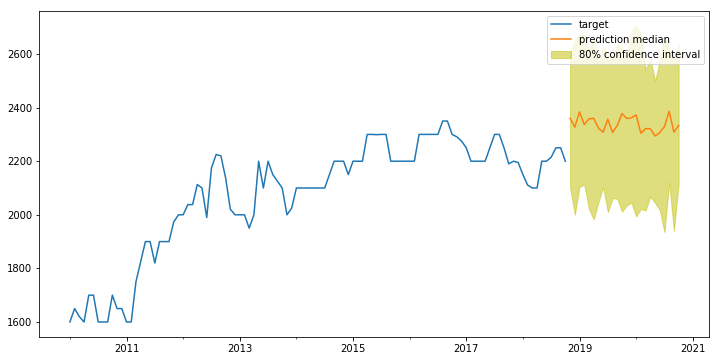

In [165]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()